# Fingerprint BigGAN
Based on [this kaggle kernel](https://www.kaggle.com/yukia18/sub-rals-ac-biggan-with-minibatchstddev). [Model description](https://www.kaggle.com/c/generative-dog-images/discussion/104211#latest-601531).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Luksalos/BIO-fingerprint-GAN/blob/master/fingerprint_BigGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Luksalos/BIO-fingerprint-GAN/blob/master/fingerprint_BigGAN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
import os
import random
import glob
import shutil
import warnings
import math
import pprint

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import xml.etree.ElementTree as ET
import albumentations as A
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from albumentations.pytorch import ToTensor
from tqdm import tqdm_notebook, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image


%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

**Kaggle versions:**               
torch                              1.3.0                
torchtext                          0.4.0               
torchvision                        0.4.1a0+d94043a 

In [3]:
pip list | grep torch

torch                    1.3.1      
torchsummary             1.5.1      
torchtext                0.3.1      
torchvision              0.4.2      


# Settings

In [0]:
config = {
    'DataLoader': {
        'batch_size': 128,
        'shuffle': True,
    },
    'Generator': {
        'latent_dim': 120,
        'embed_dim': 8,
        'ch': 64,
        'num_classes': 20,
        'use_attn': True,
    },
    'Discriminator': {
        'ch': 64,
        'num_classes': 20,
        'use_attn': True,
    },
    'sample_latents': {
        'latent_dim': 120,
        'num_classes': 20,
    },
    'num_iterations': 30000,
    'decay_start_iteration': 40000,
    'd_steps': 1,
    'lr_G': 2e-4,
    'lr_D': 4e-4,
    'betas': (0.0, 0.999),
    'margin': 1.0,
    'gamma': 0.1,
    'ema': 0.999,
    'seed': 42,
    'out_experiment_desc': 's96-crop',
    'out_base_path': f'drive/My Drive/BigGAN_outputs',
    'continue_training': True
}

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

# Get data
TODO describe how to get data


### Mount Google drive and unzip files 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%%capture
if not os.path.exists('/content/SOCOFing/'):
    !unzip 'drive/My Drive/datasets/SOCOFing.zip' -d '/content/SOCOFing/'

In [0]:
OUT_PATH = f'{config["out_base_path"]}/{config["out_experiment_desc"]}'
CHECKPOINTS_PATH = f'{OUT_PATH}/checkpoints'
GEN_IMGS_PATH = f'{OUT_PATH}/generated'
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)  # succeeds even if directory exists.
os.makedirs(GEN_IMGS_PATH, exist_ok=True)  # succeeds even if directory exists.

# Data Processing

In [0]:
# functions for images visualization
def examine_imgs(procces_img_func, data, columns=4, size=10, show_title=True):
    """
    procces_img_func - function, that take exactly one argument -> image/image_path and return processed image
    """
    rows = len(data) / columns + 1
    figsize = (size*columns, size*rows)
    f = plt.figure(figsize=figsize)
    for i, image in enumerate(data):
        img = procces_img_func(image)
        sp = f.add_subplot(rows, columns, i+1)
        sp.axis('Off')
        if show_title:
            title_text = str(i)
            # if items in data are type of string
            # if isinstance(image, str):
            #     title_text += image
            sp.set_title(title_text, fontsize=18)
        plt.imshow(img)
    plt.show()

def identity(image):
    return image

def unnormalize(image):
    # inverse operation for A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # WARNING!: works only for A.Normalize with exactly these used parameters
    return np.round(np.clip(((image + 1)/2)*255,0,255)).astype(int)[...,::-1]

def loader(image_path):
    return cv2.imread(image_path)

In [0]:
root_images = '/content/SOCOFing/Real/'

In [11]:
all_files = os.listdir(root_images)
print(all_files[:5])

['596__M_Left_thumb_finger.BMP', '185__M_Right_index_finger.BMP', '52__M_Right_thumb_finger.BMP', '175__M_Left_middle_finger.BMP', '572__F_Left_ring_finger.BMP']


### visualize some raw images


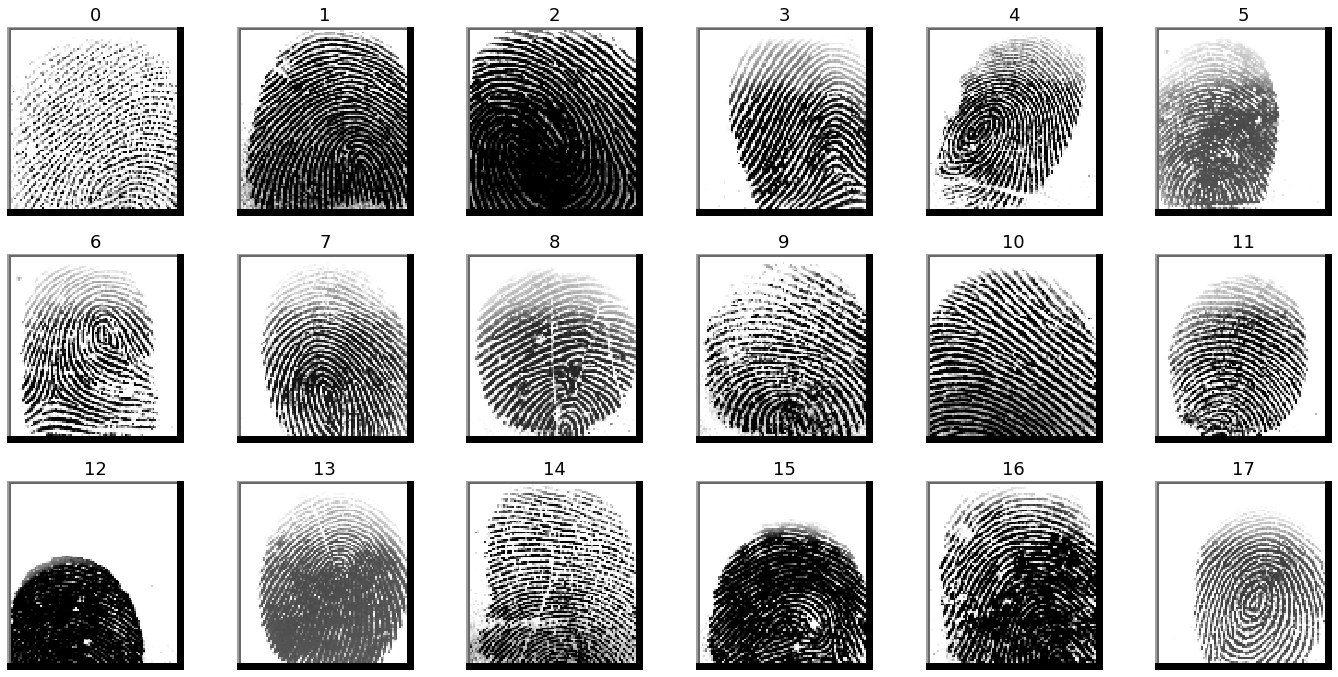

In [12]:
num_to_show = 18
full_paths = [os.path.join(root_images, image_name) for image_name in all_files[:num_to_show]]
examine_imgs(loader, full_paths, columns=6, size=4)

### Strange borders
As we can see on the pictures above, for some reason they have strange borders.  
So lets remove them  

image shape: (103, 96, 3)
Top left corner:
array([[160, 160, 160, 160, 160, 160, 160, 160],
       [160, 105, 105, 105, 105, 105, 105, 105],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255]], dtype=uint8)
Botom right corner:
array([[237,  29, 148, 187,   0,   0,   0,   0],
       [238, 224,   4,  94,   0,   0,   0,   0],
       [255, 252, 136,   0,   0,   0,   0,   0],
       [ 85, 247, 255, 199,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)


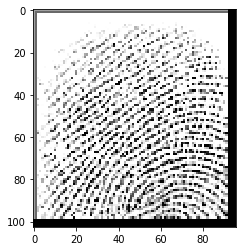

In [13]:
first_img = cv2.imread(full_paths[0])
plt.imshow(first_img)
print(f'image shape: {first_img.shape}')
print("Top left corner:")
pprint.pprint(first_img[:8,:8,1])
print("Botom right corner:")
pprint.pprint(first_img[95:103,88:96,1])

To get nice images remove 2 pixels from top and left side. + remove 4 pixel from bottom and right side

image shape: (97, 90, 3)


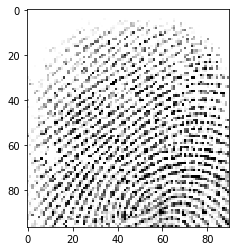

In [14]:
croped_img = first_img[2:99,2:92]
plt.imshow(croped_img)
print(f'image shape: {croped_img.shape}')

In [0]:
def load_image(file):
    img = cv2.imread(os.path.join(root_images, file))
    # Resize - 64x64 
    # img = img[2:99,2:92]
    # transform = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_AREA),
    #                        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # # crop - 64x64 
    # img = img[2:99,2:92]
    # img = img[33:97,16:80]
    # transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # # crop - 80x80
    # img = img[2:99,2:92]
    # img = img[17:97,5:85] 
    # transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # crop - 96x96
    img = img[3:99,:96]  
    img[:,:2,:] = 0 # set right border to 0 (to be the same as the right side)
    transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # # Random Crop during augmentation
    # img = img[2:99,2:92]
    # transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    return transform(image=img)['image']

all_images = [load_image(f) for f in all_files]
all_images = np.array(all_images)

In [0]:
# For Debugging
# first_img = cv2.imread(full_paths[0])
# croped_img = first_img[3:99,:96]
# croped_img[:,:2,:] = 0
# plt.imshow(croped_img)
# print(f'image shape: {croped_img.shape}')

In [17]:
def extract_label(file):
    _, label = file.split('__', 1)
    label, _ = label.split('.', 1)
    return label

all_labels = [extract_label(f) for f in all_files]
all_labels = LabelEncoder().fit_transform(all_labels)
print(all_labels[:5])

[14 15 19 12  3]


In [0]:
class FingerprintDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        # self.transform = A.Compose([A.HorizontalFlip(p=0.5), ToTensor()])
        # # Crop random 64x64 patches
        # self.transform = A.Compose([A.RandomCrop(height=64, width=64), ToTensor()])
        self.transform = A.Compose([ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = self.transform(image=img)['image']
        label = torch.as_tensor(label, dtype=torch.long)

        return img, label

In [0]:
# adding uniform noise works well.

def get_dataiterator(images, labels, dataloader_params, device='cpu'):
    train_dataset = FingerprintDataset(images, labels)
    train_dataloader = DataLoader(train_dataset, **dataloader_params)
    batch_size = dataloader_params['batch_size']

    while True:
        for imgs, labels in train_dataloader:
            if batch_size != imgs.size(0):
                break
            else:
                imgs, labels = imgs.to(device), labels.to(device)
                imgs += (1.0 / 128.0) * torch.rand_like(imgs)

                yield imgs, labels

In [0]:
# batch size around 64 ~ 128 improves score.
# ~ 64 are too small, 128 ~ are too large (for 9 hours training). 

train_dataiterator = get_dataiterator(all_images, all_labels, config['DataLoader'], device=device)

### Visualize some processed images

In [0]:
real_imgs, _ = train_dataiterator.__next__()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

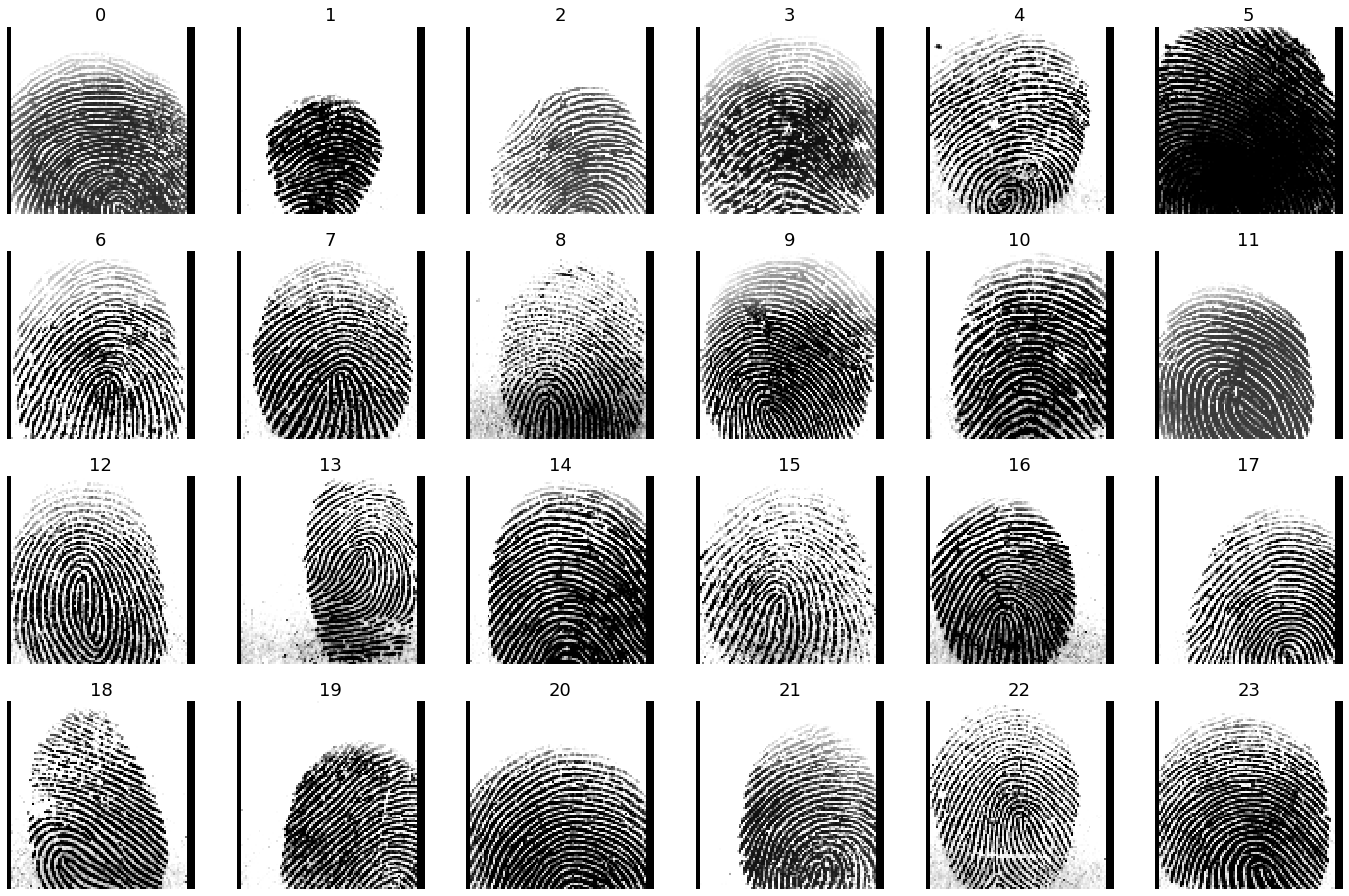

In [22]:
# TODO clip data to valid range...
examine_imgs(identity, real_imgs.permute(0,2,3,1).add_(1).div_(2).cpu().detach().numpy()[:24], columns=6, size=4)

# Models

In [0]:
# Attention slightly works.

class Attention(nn.Module):
    def __init__(self, channels, reduction_attn=8, reduction_sc=2):
        super().__init__()
        self.channles_attn = channels // reduction_attn
        self.channels_sc = channels // reduction_sc
        
        self.conv_query = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_key = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_value = spectral_norm(nn.Conv2d(channels, self.channels_sc, kernel_size=1, bias=False))
        self.conv_attn = spectral_norm(nn.Conv2d(self.channels_sc, channels, kernel_size=1, bias=False))
        self.gamma = nn.Parameter(torch.zeros(1))
        
        nn.init.orthogonal_(self.conv_query.weight.data)
        nn.init.orthogonal_(self.conv_key.weight.data)
        nn.init.orthogonal_(self.conv_value.weight.data)
        nn.init.orthogonal_(self.conv_attn.weight.data)

    def forward(self, x):
        batch, _, h, w = x.size()
        
        proj_query = self.conv_query(x).view(batch, self.channles_attn, -1)
        proj_key = F.max_pool2d(self.conv_key(x), 2).view(batch, self.channles_attn, -1)
        
        attn = torch.bmm(proj_key.permute(0,2,1), proj_query)
        attn = F.softmax(attn, dim=1)
        
        proj_value = F.max_pool2d(self.conv_value(x), 2).view(batch, self.channels_sc, -1)
        attn = torch.bmm(proj_value, attn)
        attn = attn.view(batch, self.channels_sc, h, w)
        attn = self.conv_attn(attn)
        
        out = self.gamma * attn + x
        
        return out

## Generator

In [0]:
# using label information works well.
# As for generator, it is realized by conditional batch normalization.

class CBN2d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = spectral_norm(nn.Conv2d(num_conditions, num_features*2, kernel_size=1, bias=False))
        
        nn.init.orthogonal_(self.embed.weight.data)

    def forward(self, x, y):
        out = self.bn(x)
        embed = self.embed(y.unsqueeze(2).unsqueeze(3))
        gamma, beta = embed.chunk(2, dim=1)
        out = (1.0 + gamma) * out + beta 

        return out

In [0]:
# residual block improves convergence speed and generated image's quality.
# nearest upsampling is better than others.

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conditions, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.cbn1 = CBN2d(in_channels, num_conditions)
        self.cbn2 = CBN2d(out_channels, num_conditions)
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()

        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _upsample_conv(self, x, conv):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = conv(x)
        
        return x
    
    def _residual(self, x, y):
        x = self.relu(self.cbn1(x, y))
        x = self._upsample_conv(x, self.conv1) if self.upsample else self.conv1(x)
        x = self.relu(self.cbn2(x, y))
        x = self.conv2(x)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            x = self._upsample_conv(x, self.conv_sc) if self.upsample else self.conv_sc(x)
            
        return x
    
    def forward(self, x, y):
        return self._shortcut(x) + self._residual(x, y)

In [0]:
# shared embedding of class labels, and hierarchical latent noise, work well.
# this architecture is the same as BigGAN except for channel size.

class Generator(nn.Module):
    def __init__(self, latent_dim, ch, num_classes, embed_dim, use_attn=False):
        super().__init__()
        self.latent_dim = latent_dim
        self.ch = ch
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.use_attn = use_attn
        self.num_chunk = 5
        num_latents = self.__get_num_latents()
        
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.fc = spectral_norm(nn.Linear(num_latents[0], ch*8*4*4, bias=False))
        self.block1 = GBlock(ch*8, ch*8, num_latents[1], upsample=True)
        self.block2 = GBlock(ch*8, ch*4, num_latents[2], upsample=True)
        self.block3 = GBlock(ch*4, ch*2, num_latents[3], upsample=True)
        if use_attn:
            self.attn = Attention(ch*2)
        self.block4 = GBlock(ch*2, ch, num_latents[4], upsample=True)
        self.bn = nn.BatchNorm2d(ch)
        self.relu = nn.ReLU()
        self.conv_last = spectral_norm(nn.Conv2d(ch, 3, kernel_size=3, padding=1, bias=False))
        self.tanh = nn.Tanh()
        
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.conv_last.weight.data)
        nn.init.constant_(self.bn.weight.data, 1.0)
        nn.init.constant_(self.bn.bias.data, 0.0)
    
    def __get_num_latents(self):
        xs = torch.empty(self.latent_dim).chunk(self.num_chunk)
        num_latents = [x.size(0) for x in xs]
        for i in range(1, self.num_chunk):
            num_latents[i] += self.embed_dim
        
        return num_latents
    
    def forward(self, x, y):
        xs = x.chunk(self.num_chunk, dim=1)
        y = self.embed(y)
        
        h = self.fc(xs[0])
        h = h.view(h.size(0), self.ch*8, 4, 4)
        h = self.block1(h, torch.cat([y, xs[1]], dim=1))
        h = self.block2(h, torch.cat([y, xs[2]], dim=1))
        h = self.block3(h, torch.cat([y, xs[3]], dim=1))
        if self.use_attn:
            h = self.attn(h)
        h = self.block4(h, torch.cat([y, xs[4]], dim=1))
        h = self.relu(self.bn(h))
        out = self.tanh(self.conv_last(h))
        
        return out

## Discriminator

In [0]:
# residual block improves convergence speed and generated image's quality.

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, optimized=False):
        super().__init__()
        self.downsample = downsample
        self.optimized = optimized
        self.learnable_sc = in_channels != out_channels or downsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()
        
        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)

    def _residual(self, x):
        if not self.optimized:
            x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            if self.optimized:
                x = self.conv_sc(F.avg_pool2d(x, 2)) if self.downsample else self.conv_sc(x)
            else:
                x = F.avg_pool2d(self.conv_sc(x), 2) if self.downsample else self.conv_sc(x)
        
        return x
    
    def forward(self, x):
        return self._shortcut(x) + self._residual(x)

In [0]:
# this architecture is the altered version of BigGAN Discriminator.
# <- using residual block, projection.

# but those points are different from original.
# - reduce channel size.
# - reduce model depth (remove last residual block).
# - add minibatch stddev.
# - with auxiliary classifier (ACGAN).
#   <- improve image's quality and stabilize training.

class Discriminator(nn.Module):
    def __init__(self, ch, num_classes, use_attn=False):
        super().__init__()
        self.ch = ch
        self.num_classes = num_classes
        self.use_attn = use_attn
        
        self.block1 = DBlock(3, ch, downsample=True, optimized=True)
        if use_attn:
            self.attn = Attention(ch)
        self.block2 = DBlock(ch, ch*2, downsample=True)
        self.block3 = DBlock(ch*2, ch*4, downsample=True)
        self.block4 = DBlock(ch*4, ch*8, downsample=True)
        self.block5 = DBlock(ch*8+1, ch*8, downsample=False)
        self.relu = nn.ReLU()
        self.fc = spectral_norm(nn.Linear(ch*8, 1, bias=False))
        self.embed = spectral_norm(nn.Embedding(num_classes, ch*8))
        self.clf = spectral_norm(nn.Linear(ch*8, num_classes, bias=False))
        
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.clf.weight.data)
    
    def minibatch_stddev(self, x, group_size=4, eps=1e-8):
        shape = x.size()
        y = x.view(group_size, -1, shape[1], shape[2], shape[3])
        y -= torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(y.pow(2), dim=0)
        y = torch.sqrt(y + eps)
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        y = y.repeat(group_size, 1, shape[2], shape[3])

        return torch.cat([x, y], dim=1)
    
    def forward(self, x, y):
        h = self.block1(x)
        if self.use_attn:
            h = self.attn(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(self.minibatch_stddev(h))
        h = self.relu(h)
        h = torch.sum(h, dim=(2,3))
        
        out = self.fc(h)
        out += torch.sum(self.embed(y)*h, dim=1, keepdim=True)
        
        ac = self.clf(h)
        ac = F.log_softmax(ac, dim=1)
        
        return out, ac

# Train GANs

In [0]:
netG = Generator(**config['Generator']).to(device, torch.float32)
netD = Discriminator(**config['Discriminator']).to(device, torch.float32)

In [0]:
# Exponential moving average of generator weights works well.
# Got error, when updating netGE buffers

# netGE = Generator(**config['Generator']).to(device, torch.float32)
# netGE.load_state_dict(netG.state_dict());

In [0]:
optim_G = Adam(params=netG.parameters(), lr=config['lr_G'], betas=config['betas'])
optim_D = Adam(params=netD.parameters(), lr=config['lr_D'], betas=config['betas'])

In [0]:
decay_iter = config['num_iterations'] - config['decay_start_iteration']
if decay_iter > 0:
    lr_lambda_G = lambda x: (max(0,1-x/decay_iter))
    lr_lambda_D = lambda x: (max(0,1-x/(decay_iter*config['d_steps'])))
    lr_sche_G = LambdaLR(optim_G, lr_lambda=lr_lambda_G)
    lr_sche_D = LambdaLR(optim_D, lr_lambda=lr_lambda_D)

In [0]:
def calc_advloss_D(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() - margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() + margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [0]:
def calc_advloss_G(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() + margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() - margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [0]:
# auxiliary classifier loss.
# this loss weighted by gamma (0.1) is added to adversarial loss.
# coefficient gamma is quite sensitive.

criterion = nn.NLLLoss().to(device, torch.float32)

In [0]:
def sample_latents(batch_size, latent_dim, num_classes):
    latents = torch.randn((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels = torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    return latents, labels

In [0]:
# Only for testing
# counter = 0
# for buffer_G, buffer_GE in zip(netG.buffers(), netGE.buffers()):
#     if counter == 8:
#         print(buffer_G)
#         print(buffer_GE.data.mul_(1).add_(0*buffer_G.data))
#         print(buffer_G)
#     print(counter)
#     # buffer_GE.data.mul_(config['ema']).add_((1-config['ema'])*buffer_G.data)
    
#     counter += 1
#     # buffer_GE.data.mul_(config['ema']).add_((1-config['ema'])*buffer_G.data)
# counter

In [0]:
def truncated_normal(size, threshold=2.0, dtype=torch.float32, device='cpu'):
    x = scipy.stats.truncnorm.rvs(-threshold, threshold, size=size)
    x = torch.from_numpy(x).to(device, dtype)

    return x

In [0]:
def generate_eval_samples(generator, batch_size, latent_dim, num_classes):
    latents = truncated_normal((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels =  torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    with torch.no_grad():
        imgs = (generator(latents, labels) + 1) / 2
    
    return imgs

In [0]:
def gen_and_save_some_images(step, repeatch_each_class=2, nrow=8):
    split_size = 50

    latent_dim = config['sample_latents']['latent_dim']
    num_classes = config['sample_latents']['num_classes']

    all_labels = torch.arange(num_classes, dtype=torch.long, device=device)
    all_labels = all_labels.repeat_interleave(repeatch_each_class)
    labels_split = all_labels.split(split_size)

    imgs_list = []
    for labels in labels_split:
        batch_size = labels.size(0)
        latents = truncated_normal((batch_size, latent_dim), threshold=1.5, dtype=torch.float32, device=device)
        with torch.no_grad():
            # imgs = (netGE(latents, labels) + 1) / 2
            imgs = (netG(latents, labels) + 1) / 2
            imgs_list.append(imgs)
        
    all_imgs = torch.cat(imgs_list, dim=0)
    all_imgs = make_grid(all_imgs, nrow=nrow, normalize=False)
    all_imgs = all_imgs.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

    img.imsave(f'{GEN_IMGS_PATH}/step-{step:05}.png', all_imgs)
    # plt.figure(figsize=(2*nrow, 2*(num_classes*repeatch_each_class)//nrow))
    # plt.imshow(all_imgs);

In [41]:
# Determine the last step the model reached in some previous run.
# This should handle two situations where an inconsistency could have occured
# due to early termination of the run:
#   * either the new model was stored for generator but not discriminator,
#   * or the old model was deleted for generator but not discriminator.
def step_number(netX_path):
    return int(oldest_netG.split("/")[-1][5:-3])

if config['continue_training']:
    prev_netG = glob.glob(f'{CHECKPOINTS_PATH}/netG-*.pt')
    prev_netD = glob.glob(f'{CHECKPOINTS_PATH}/netD-*.pt')
    prev_step = 1
    if prev_netG and prev_netD:
        prev_netG.sort(reverse=True)
        prev_netD.sort(reverse=True)
        # print(prev_netG)
        # print(prev_netD)
        oldest_netG = prev_netG[0]
        oldest_netD = prev_netD[0]
        oldest_netG_step = step_number(oldest_netG)
        oldest_netD_step = step_number(oldest_netD)
        assert(oldest_netG_step == oldest_netD_step)
        prev_step = oldest_netG_step
        # Load the models from previous run.
        netG.load_state_dict(torch.load(f'{CHECKPOINTS_PATH}/netG-{prev_step}.pt'))
        netD.load_state_dict(torch.load(f'{CHECKPOINTS_PATH}/netD-{prev_step}.pt'))
    print(f'last checkpoint step: {prev_step}')

last checkpoint step: 9600


In [42]:
# todo: figure out, why it keeps printing new lines (sometimes it works, its pretty retarded :/)
for step in trange(prev_step, config['num_iterations'], initial=prev_step):
    # Discriminator
    for i in range(config['d_steps']):
        for param in netD.parameters():
            param.requires_grad_(True)
    
        optim_D.zero_grad()

        real_imgs, real_labels = train_dataiterator.__next__()
        batch_size = real_imgs.size(0)

        latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
        fake_imgs = netG(latents, fake_labels).detach()
        
        preds_real, preds_real_labels = netD(real_imgs, real_labels)
        preds_fake, _ = netD(fake_imgs, fake_labels)

        loss_D = calc_advloss_D(preds_real, preds_fake, config['margin'])
        loss_D += config['gamma'] * criterion(preds_real_labels, real_labels)
        loss_D.backward()
        optim_D.step()
        
        if (decay_iter > 0) and (step > config['decay_start_iteration']):
            lr_sche_D.step()

    # Generator
    for param in netD.parameters():
        param.requires_grad_(False)

    optim_G.zero_grad()
    
    real_imgs, real_labels = train_dataiterator.__next__()
    batch_size = real_imgs.size(0)
    
    latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
    fake_imgs = netG(latents, fake_labels)

    preds_real, _ = netD(real_imgs, real_labels)
    preds_fake, preds_fake_labels = netD(fake_imgs, fake_labels)

    loss_G = calc_advloss_G(preds_real, preds_fake, config['margin'])
    loss_G += config['gamma'] * criterion(preds_fake_labels, fake_labels)
    loss_G.backward()
    optim_G.step()
    
    if (decay_iter > 0) and (step > config['decay_start_iteration']):
        lr_sche_G.step()

    # Save checkpoints every 400th step
    if step % 400 == 0:
        torch.save(netG.state_dict(), f"{CHECKPOINTS_PATH}/netG-{step}.pt")
        torch.save(netD.state_dict(), f"{CHECKPOINTS_PATH}/netD-{step}.pt")

    if step % 200 == 0:
        gen_and_save_some_images(step)

    # Got this error: result type Float can't be cast to the desired output type Long
    # Exponential Moving Average (EMA) - https://openreview.net/forum?id=SJgw_sRqFQ
    # Update Generator Eval
    # for param_G, param_GE in zip(netG.parameters(), netGE.parameters()):
    #     param_GE.data.mul_(config['ema']).add_((1-config['ema'])*param_G.data)
    # for buffer_G, buffer_GE in zip(netG.buffers(), netGE.buffers()):
    #     buffer_GE.data.mul_(config['ema']).add_((1-config['ema'])*buffer_G.data)

 47%|████▋     | 9604/20400 [00:19<15:10:20,  5.06s/it]

KeyboardInterrupt: ignored

# Generate Samples

In [0]:
def make_submissions(generator, user_images_unzipped_path, latent_dim, num_classes):
    if not os.path.exists(user_images_unzipped_path):
        os.mkdir(user_images_unzipped_path)
    
    sample_batch_size = 50
    num_samples = 10000
    
    for i in range(0, num_samples, sample_batch_size):
        imgs = generate_eval_samples(generator, sample_batch_size, latent_dim, num_classes)
        for j, img in enumerate(imgs):
            save_image(img, os.path.join(user_images_unzipped_path, f'image_{i+j:05d}.png'))
    
    shutil.make_archive('images', 'zip', user_images_unzipped_path)

In [0]:
# user_images_unzipped_path = '../output_images'
# make_submissions(netGE, user_images_unzipped_path, **config['sample_latents'])

# See some examples

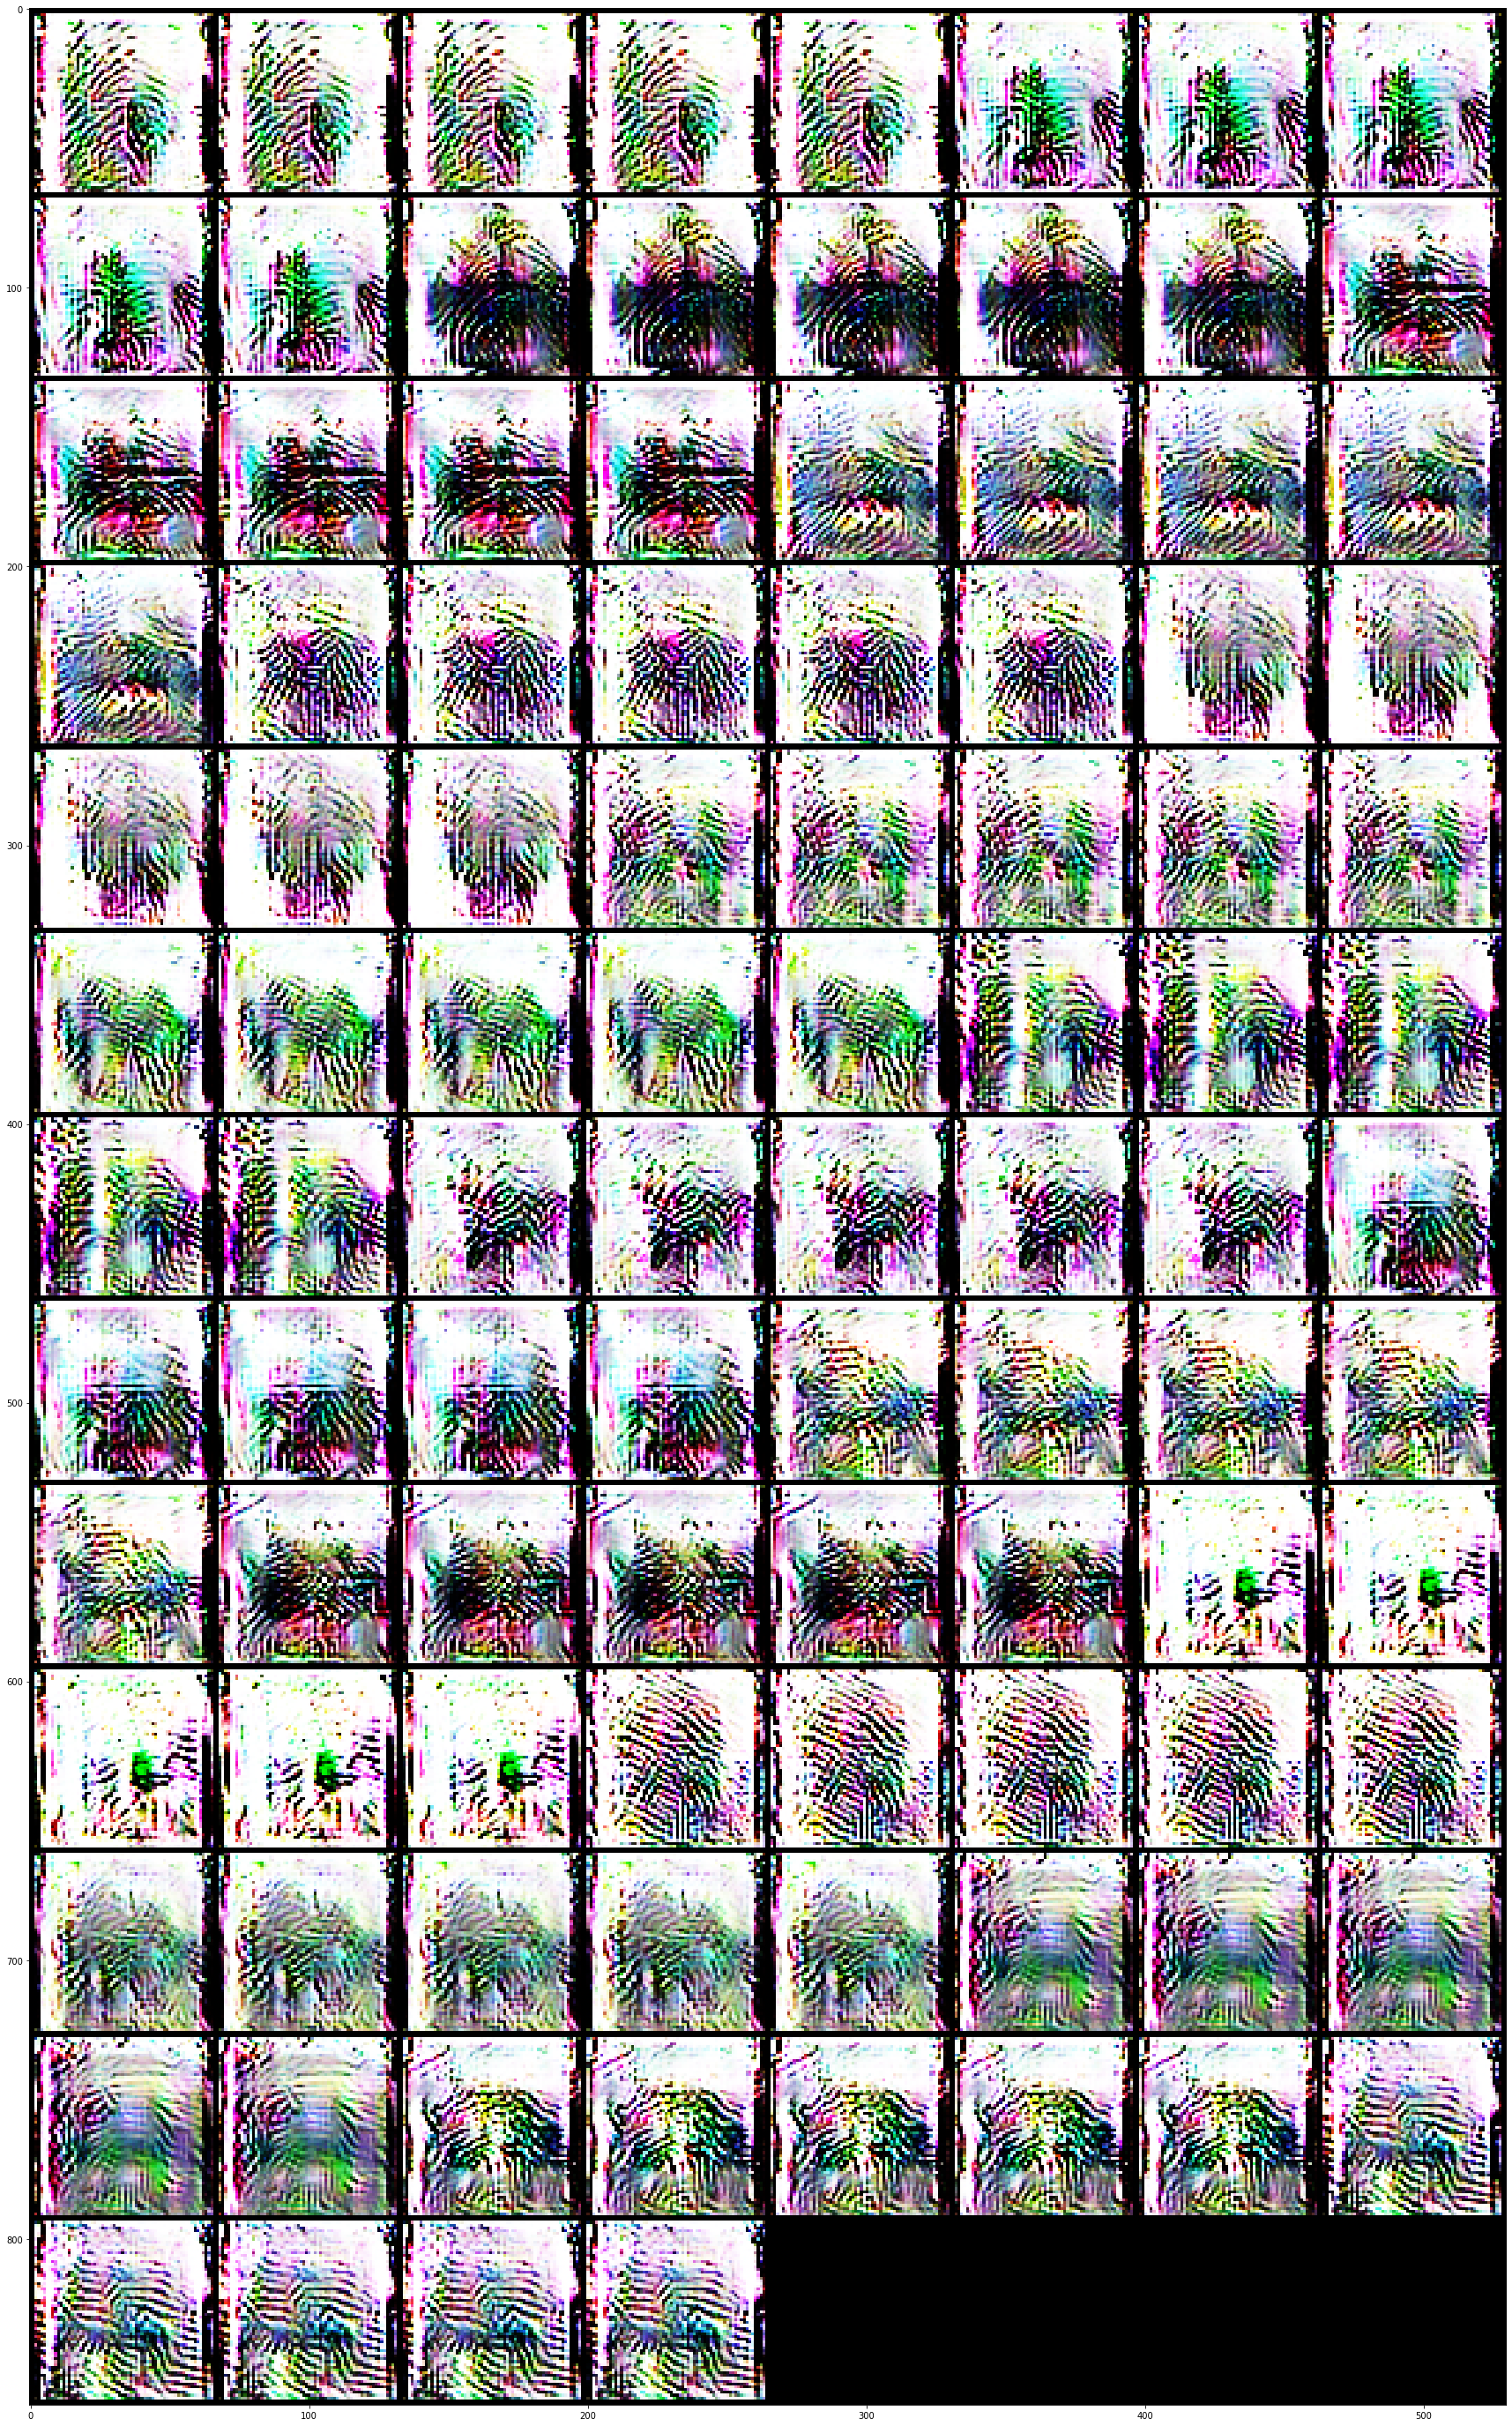

In [43]:
repeat_breeds = 5
nrow = 8
split_size = 50

latent_dim = config['sample_latents']['latent_dim']
num_classes = config['sample_latents']['num_classes']

all_labels = torch.arange(num_classes, dtype=torch.long, device=device)
all_labels = all_labels.repeat_interleave(repeat_breeds)
labels_split = all_labels.split(split_size)

imgs_list = []
for labels in labels_split:
    batch_size = labels.size(0)
    latents = truncated_normal((batch_size, latent_dim), threshold=1.5, dtype=torch.float32, device=device)
    with torch.no_grad():
        # imgs = (netGE(latents, labels) + 1) / 2
        imgs = (netG(latents, labels) + 1) / 2
        imgs_list.append(imgs)
    
all_imgs = torch.cat(imgs_list, dim=0)
all_imgs = make_grid(all_imgs, nrow=nrow, normalize=False)
all_imgs = all_imgs.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

plt.figure(figsize=(4*nrow, 4*(num_classes*repeat_breeds)//nrow))
plt.imshow(all_imgs);